In [2]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels

# basic + dates 
import numpy as np
import pandas as pd
from datetime import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except:
    pass

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet（推荐使用新版）
from prophet import Prophet


In [12]:
#读取时间序列训练数据和商店信息数据，并设置好时间索引，准备后续分析或建模
# importing train data to learn
train = pd.read_csv("/root/7102/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("/root/7102/store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [14]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(10)

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2015-07-31,6,5,5651,589,1,1,0,1
2015-07-31,7,5,15344,1414,1,1,0,1
2015-07-31,8,5,8492,833,1,1,0,1
2015-07-31,9,5,8565,687,1,1,0,1


In [16]:
#为时间序列销售数据提取时间特征并创建一个新变量，常用于销售预测、时间序列建模前的数据准备阶段。
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week  # 替代旧的 .weekofyear

train['SalePerCustomer'] = train['Sales'] / train['Customers']
train['SalePerCustomer'].describe()


count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

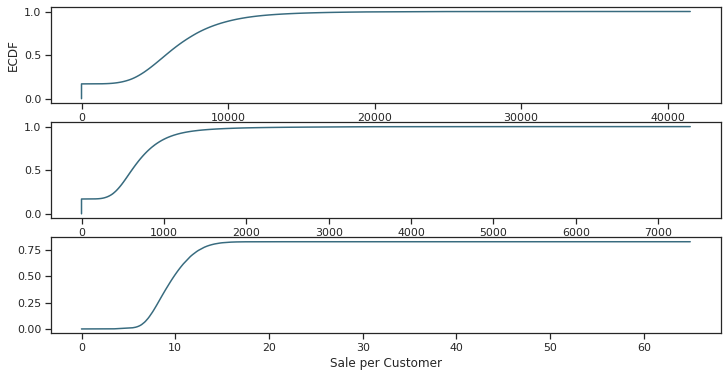

In [17]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [18]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [19]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [20]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)


Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


In [21]:
# additional information about the stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [22]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [23]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [24]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [25]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [26]:
# replace NA's by 0
store.fillna(0, inplace = True)
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [27]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [32]:
#按门店类型计算平均每位顾客消费
train_store.groupby('StoreType')[['Customers', 'Sales']].sum()

grouped = train_store.groupby('StoreType')[['Customers', 'Sales']].sum()
grouped['SalePerCustomer'] = grouped['Sales'] / grouped['Customers']
print(grouped)


           Customers       Sales  SalePerCustomer
StoreType                                        
a          363541431  3165334859         8.706944
b           31465616   159231395         5.060489
c           92129705   783221426         8.501291
d          156904995  1765392943        11.251350


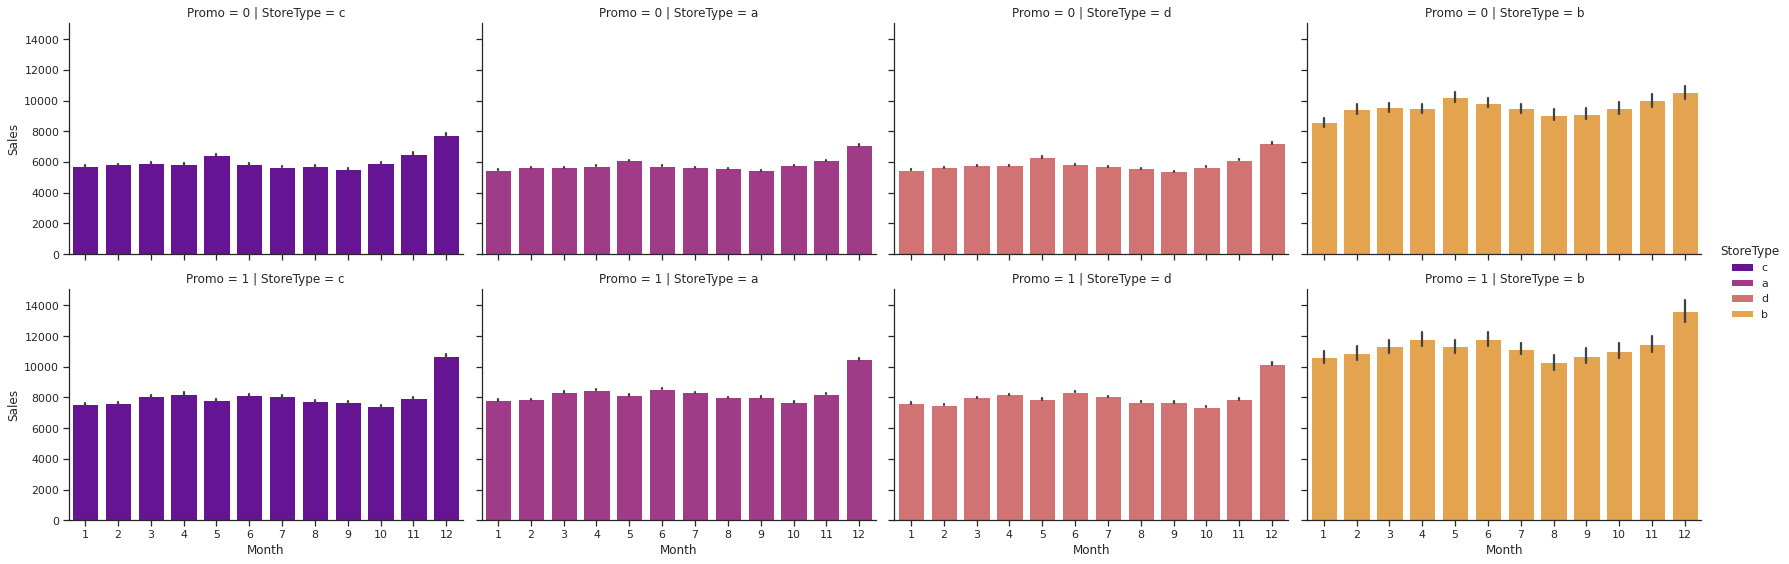

In [34]:
sns.catplot(data=train_store, x='Month', y='Sales',
            col='StoreType', row='Promo',
            hue='StoreType', palette='plasma',
            kind='bar',  # or 'box', 'point' etc.
            height=4, aspect=1.5)


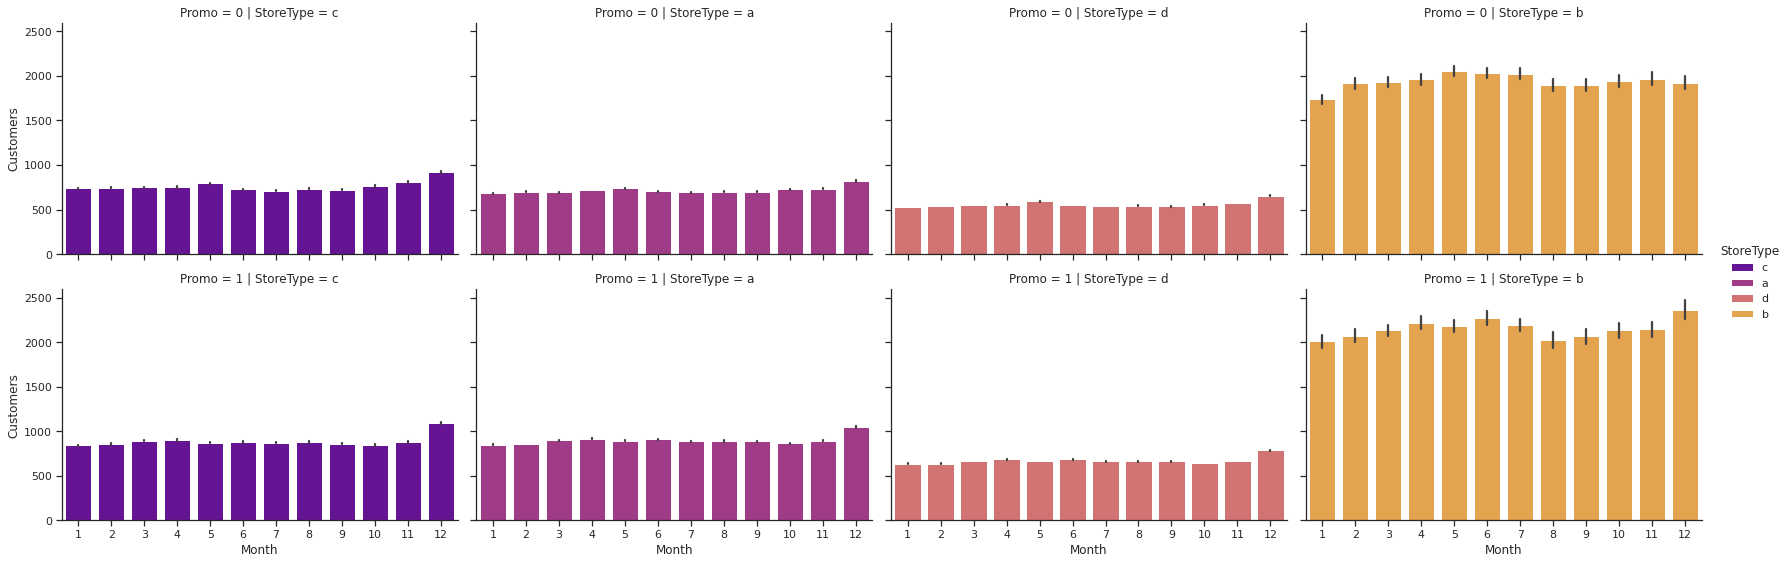

In [35]:
sns.catplot(data=train_store, x='Month', y='Customers',
            col='StoreType', row='Promo',
            hue='StoreType',
            palette='plasma',
            kind='bar',          # 你可以改成 'point' 或 'box' 看不同效果
            height=4, aspect=1.5)


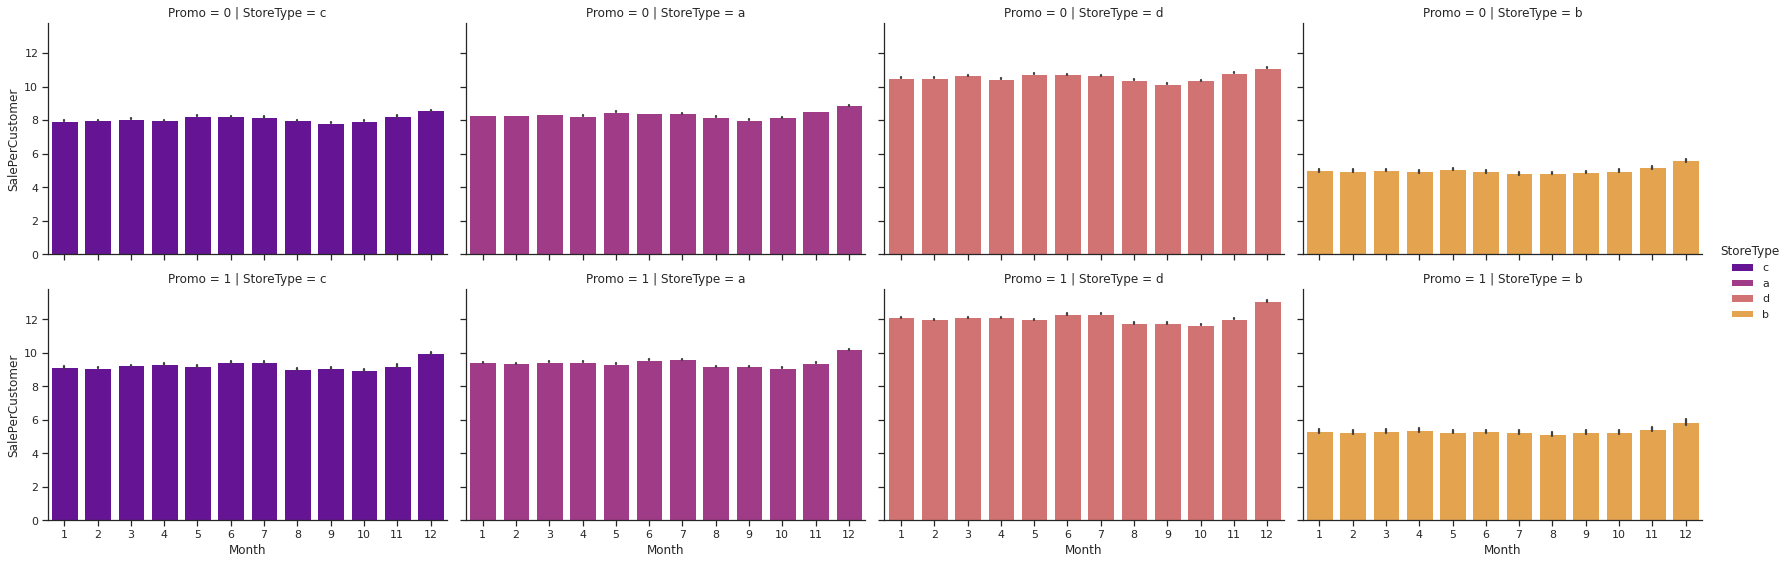

In [36]:
sns.catplot(data=train_store, x='Month', y='SalePerCustomer',
            col='StoreType', row='Promo',
            hue='StoreType', palette='plasma',
            kind='bar', height=4, aspect=1.5)


In [ ]:
data=train_store：你的数据集

x='Month'：横坐标是月份

y='SalePerCustomer'：纵坐标是人均消费额

col='StoreType'：每种门店类型一个子图列

row='Promo'：是否促销做行分类

hue='StoreType'：颜色区分门店类型

palette='plasma'：使用 seaborn 的 plasma 调色板

kind='bar'：用柱状图表示趋势（也可以改成 'point' 看折线）

height=4, aspect=1.5：子图大小设置

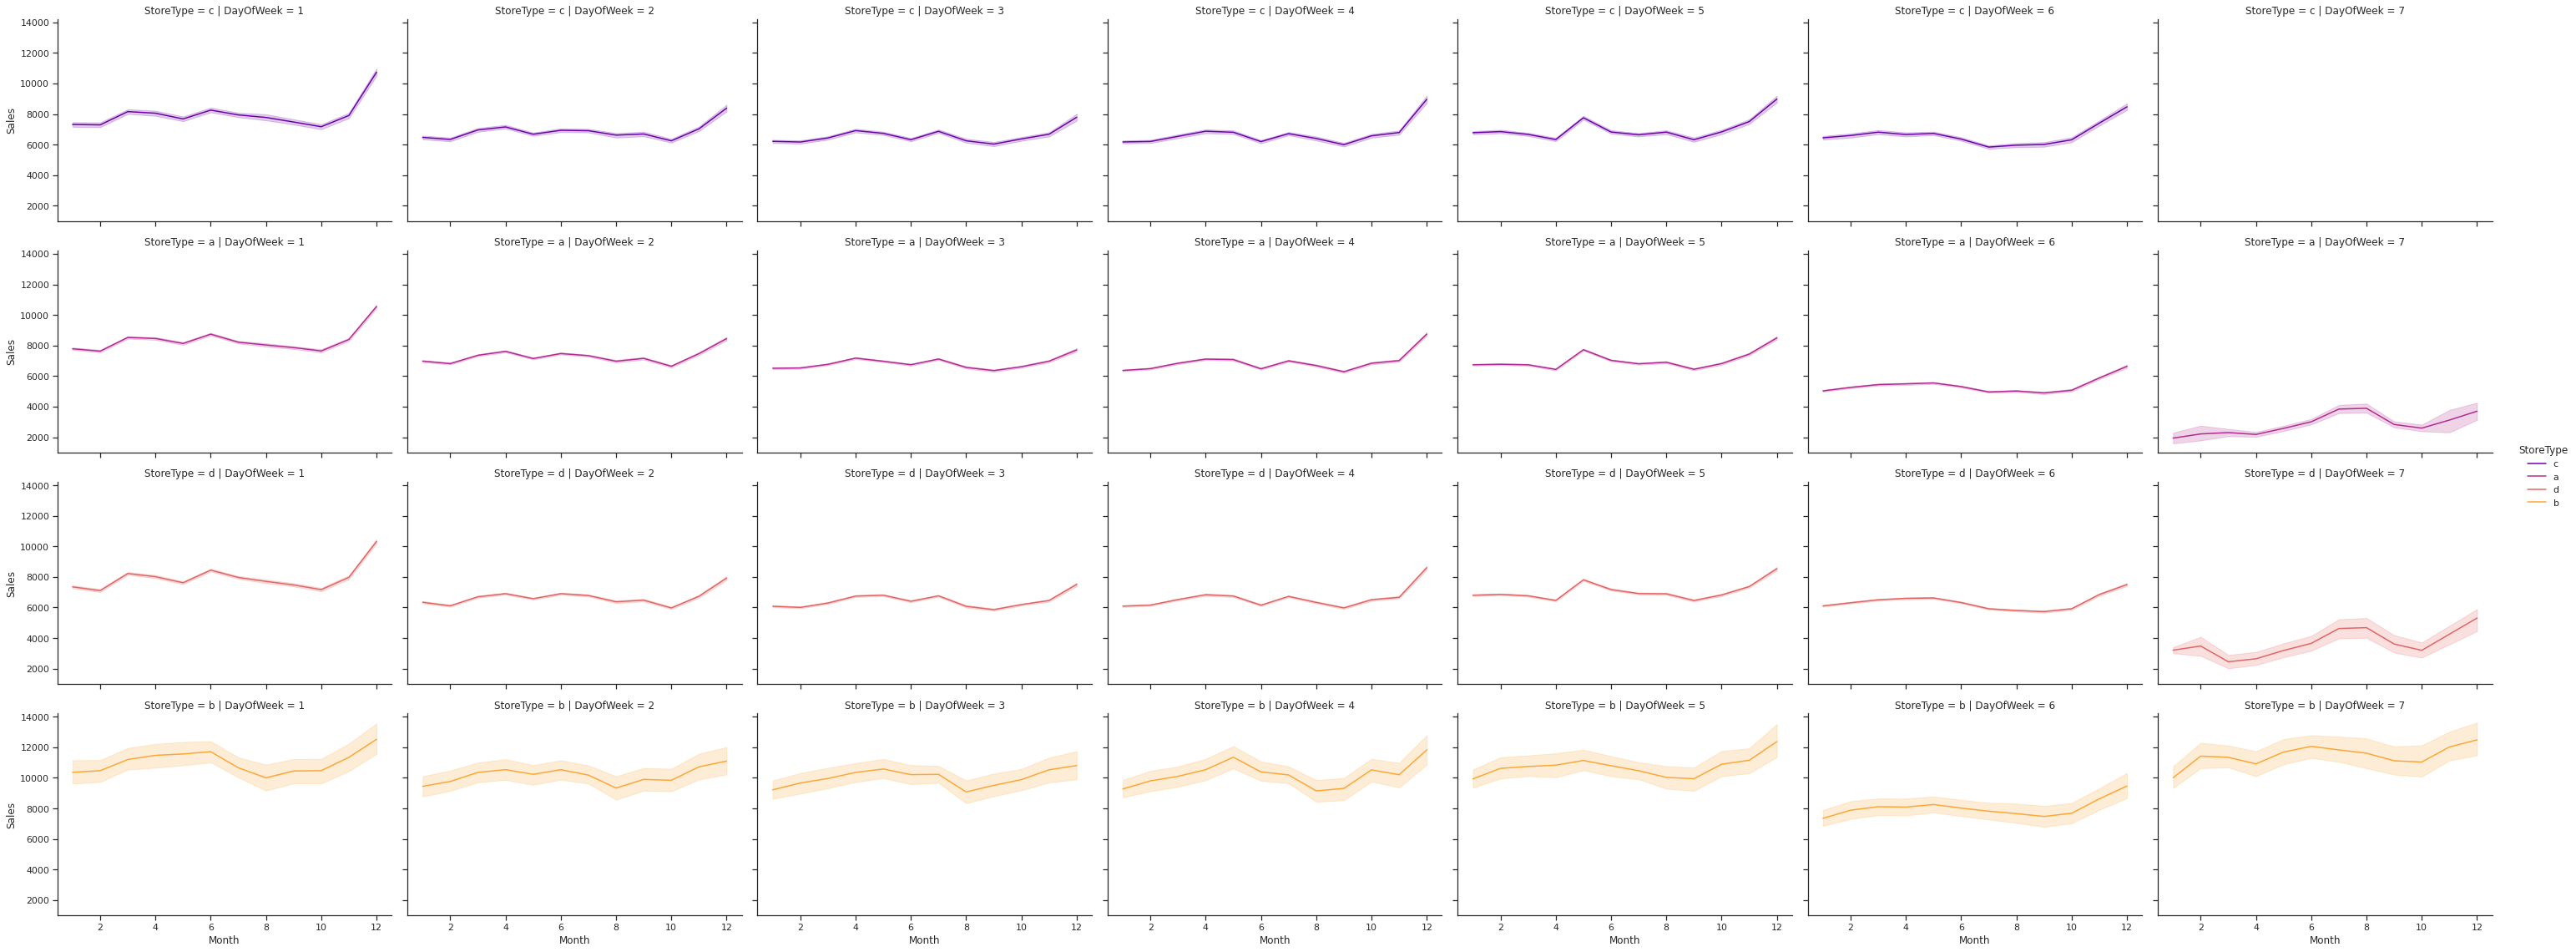

In [37]:
sns.relplot(data=train_store, x='Month', y='Sales',
            col='DayOfWeek',     # 每列是星期几（1~7）
            row='StoreType',     # 每行是门店类型
            hue='StoreType',     # 用颜色区分门店类型
            kind='line',         # 折线图
            palette='plasma',
            height=4, aspect=1.5)


In [38]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

In [39]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


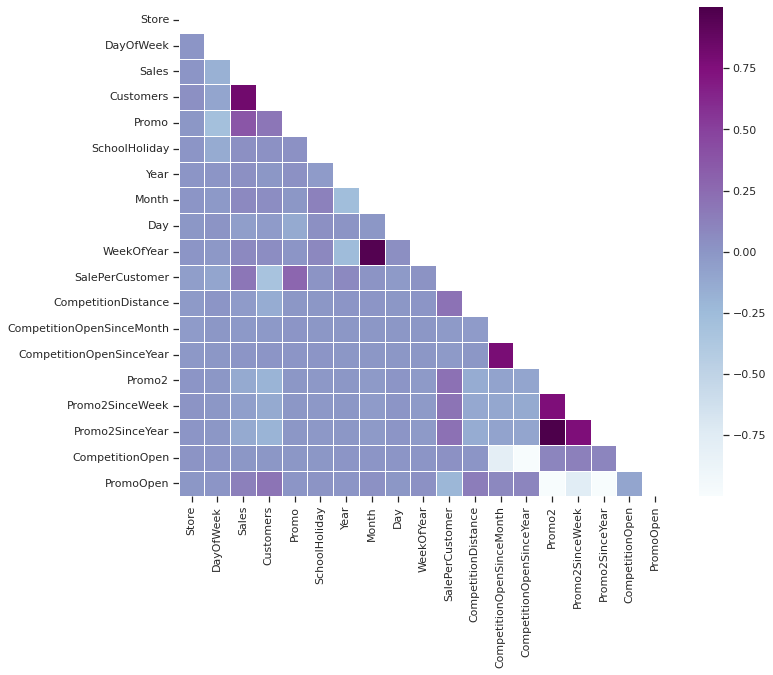

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 只取数值型列并去掉 'Open'
corr_all = train_store.drop('Open', axis=1).select_dtypes(include='number').corr()

# 生成上三角遮罩
mask = np.zeros_like(corr_all, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 绘图
plt.figure(figsize=(11, 9))
sns.heatmap(corr_all, mask=mask, square=True, linewidths=.5, cmap='BuPu')
plt.show()


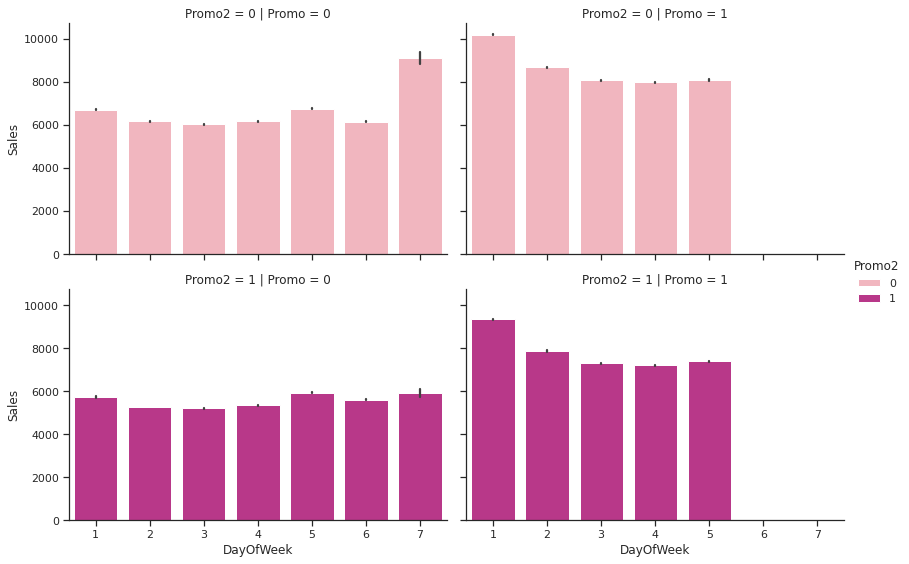

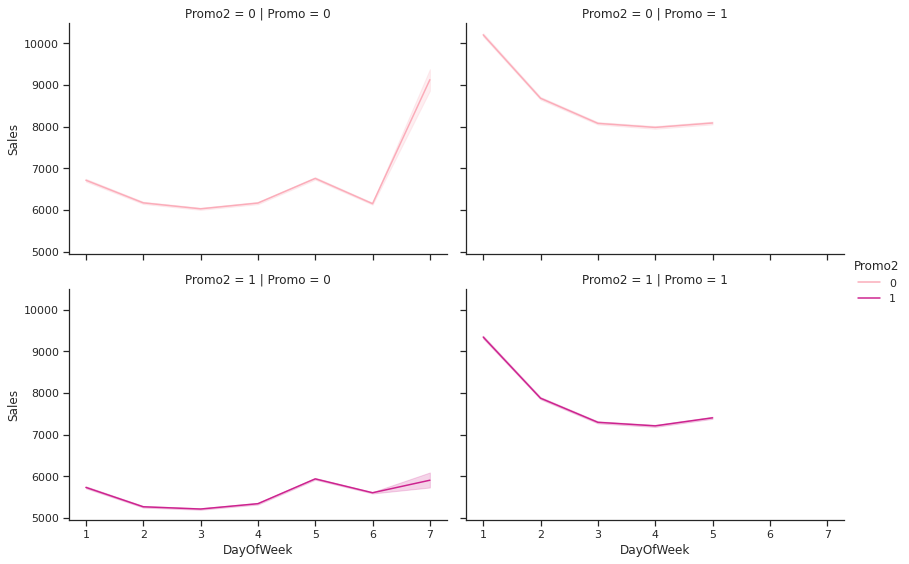

In [43]:
sns.catplot(data=train_store, x='DayOfWeek', y='Sales',
            col='Promo', row='Promo2',
            hue='Promo2', palette='RdPu',
            kind='bar', height=4, aspect=1.5)

sns.relplot(data=train_store, x='DayOfWeek', y='Sales',
            col='Promo', row='Promo2',
            hue='Promo2', palette='RdPu',
            kind='line', height=4, aspect=1.5)


<AxesSubplot:xlabel='Date'>

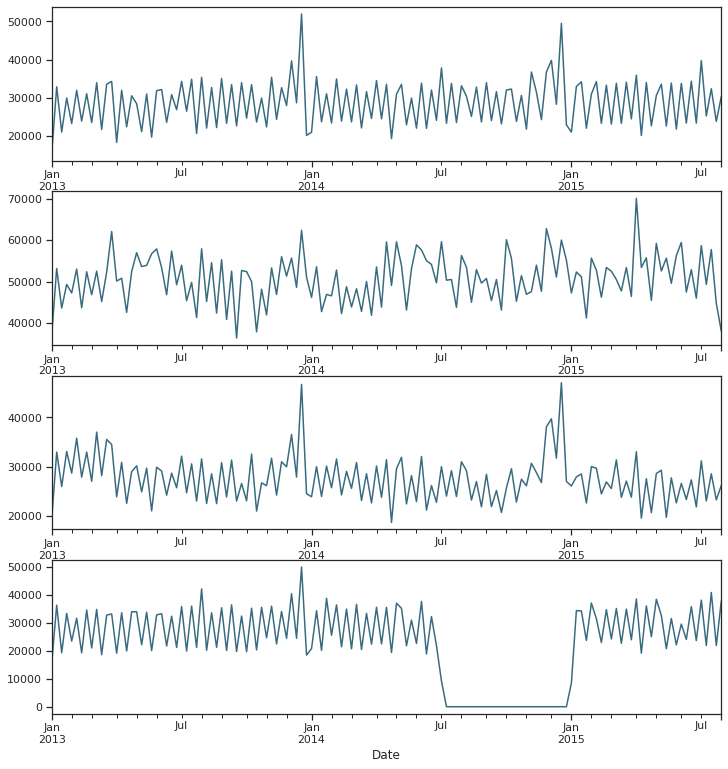

In [44]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

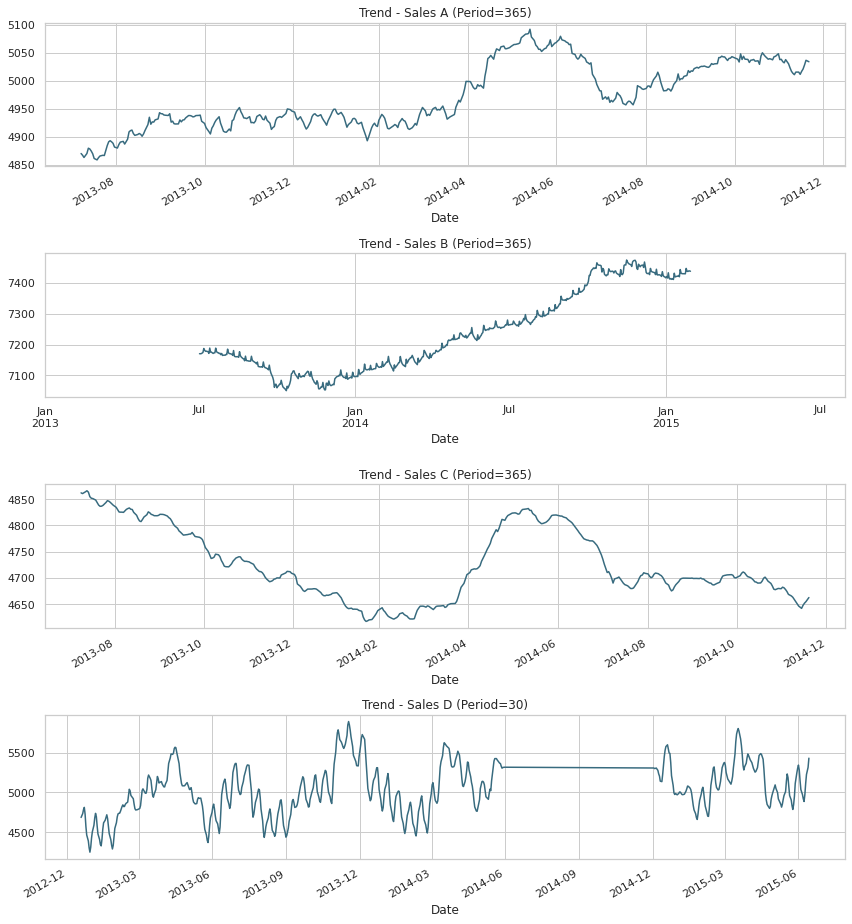

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# 设置样式和颜色
sns.set(style='whitegrid')
c = '#386B7F'

# 创建绘图区域（4行子图）
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))

# =====================
# A 销售趋势
# =====================
period_a = 365 if len(sales_a) >= 730 else 30
decomposition_a = seasonal_decompose(sales_a, model='additive', period=period_a)
decomposition_a.trend.plot(color=c, ax=ax1)
ax1.set_title(f"Trend - Sales A (Period={period_a})")

# =====================
# B 销售趋势
# =====================
period_b = 365 if len(sales_b) >= 730 else 30
decomposition_b = seasonal_decompose(sales_b, model='additive', period=period_b)
decomposition_b.trend.plot(color=c, ax=ax2)
ax2.set_title(f"Trend - Sales B (Period={period_b})")

# =====================
# C 销售趋势
# =====================
period_c = 365 if len(sales_c) >= 730 else 30
decomposition_c = seasonal_decompose(sales_c, model='additive', period=period_c)
decomposition_c.trend.plot(color=c, ax=ax3)
ax3.set_title(f"Trend - Sales C (Period={period_c})")

# =====================
# D 销售趋势（先检查数据量）
# =====================
if len(sales_d) >= 60:  # 至少保证2个月数据（若周期用30）
    period_d = 365 if len(sales_d) >= 730 else 30
    decomposition_d = seasonal_decompose(sales_d, model='additive', period=period_d)
    decomposition_d.trend.plot(color=c, ax=ax4)
    ax4.set_title(f"Trend - Sales D (Period={period_d})")
else:
    ax4.set_title("Sales D 数据太少，无法进行季节性分解")
    ax4.text(0.5, 0.5, "数据不足", fontsize=14, ha='center')

# =====================
# 调整布局，展示图像
# =====================
plt.tight_layout()
plt.show()


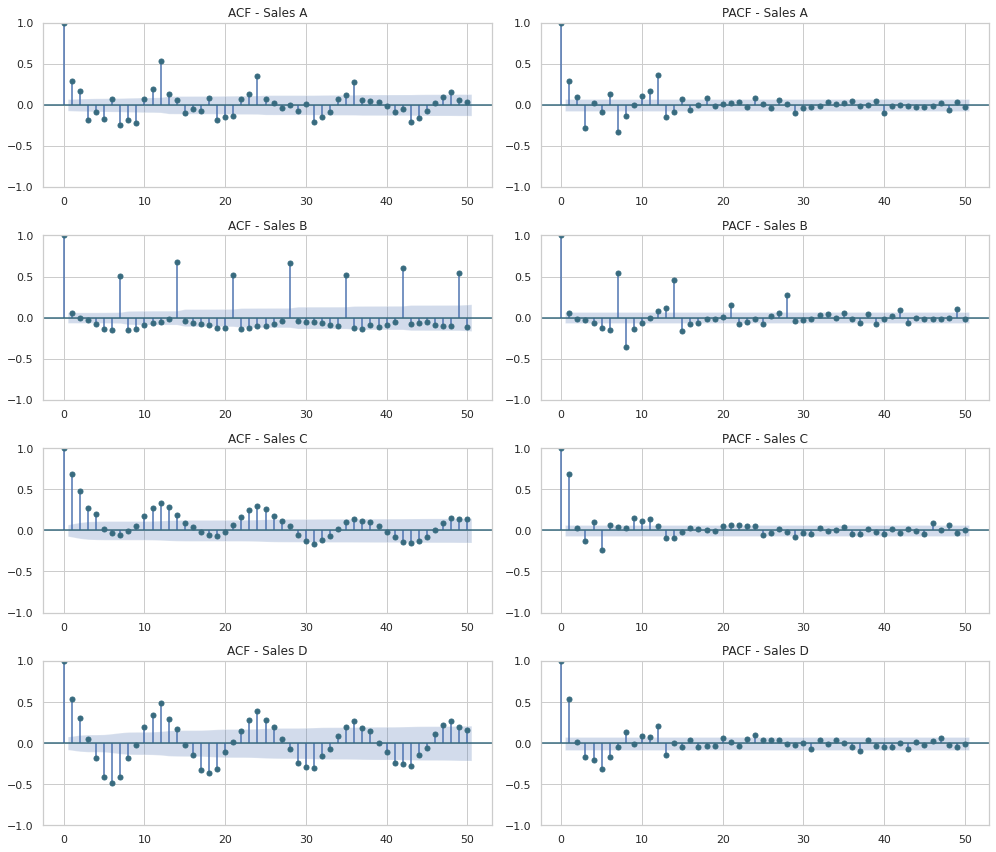

In [49]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置颜色
c = '#386B7F'

# 创建 4x2 的子图布局
fig, axes = plt.subplots(4, 2, figsize=(14, 12))  # 更大更清晰

# A
plot_acf(sales_a, lags=50, ax=axes[0, 0], color=c)
axes[0, 0].set_title("ACF - Sales A")

plot_pacf(sales_a, lags=50, ax=axes[0, 1], color=c)
axes[0, 1].set_title("PACF - Sales A")

# B
plot_acf(sales_b, lags=50, ax=axes[1, 0], color=c)
axes[1, 0].set_title("ACF - Sales B")

plot_pacf(sales_b, lags=50, ax=axes[1, 1], color=c)
axes[1, 1].set_title("PACF - Sales B")

# C
plot_acf(sales_c, lags=50, ax=axes[2, 0], color=c)
axes[2, 0].set_title("ACF - Sales C")

plot_pacf(sales_c, lags=50, ax=axes[2, 1], color=c)
axes[2, 1].set_title("PACF - Sales C")

# D
plot_acf(sales_d, lags=50, ax=axes[3, 0], color=c)
axes[3, 0].set_title("ACF - Sales D")

plot_pacf(sales_d, lags=50, ax=axes[3, 1], color=c)
axes[3, 1].set_title("PACF - Sales D")

# 自动调整子图间距，防止重叠
plt.tight_layout()
plt.show()


In [51]:
# importing data
df = pd.read_csv("/root/7102/train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [52]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


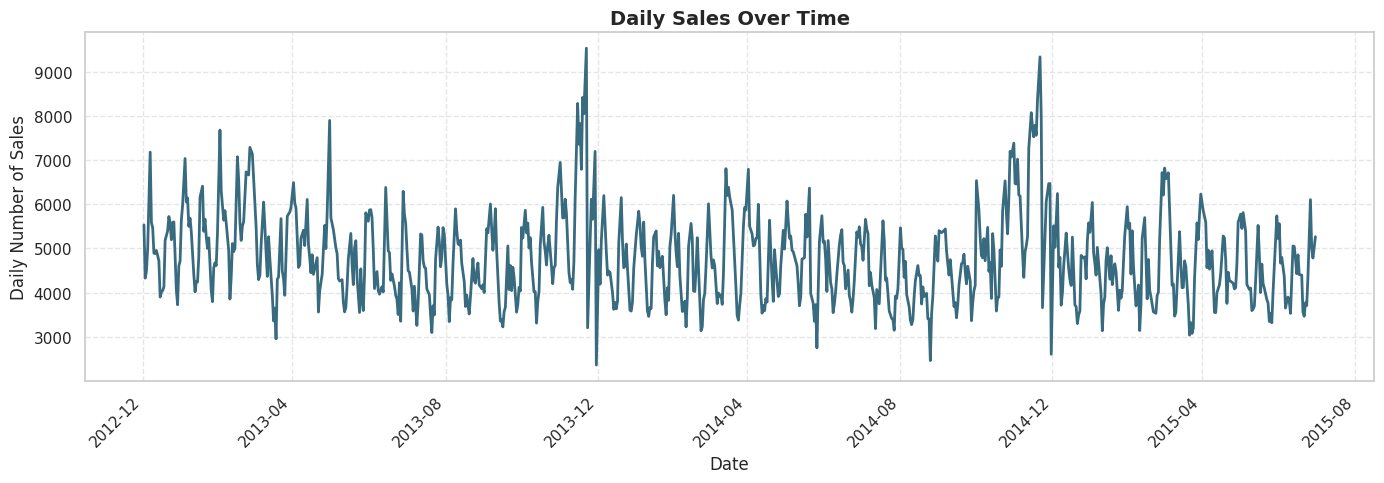

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格（seaborn 会让图更有层次感）
sns.set(style="whitegrid", context="notebook")

# 设置颜色（你已有变量 c）
c = "#386B7F"

# 设置图像大小和 DPI（提升清晰度）
fig, ax = plt.subplots(figsize=(14, 5), dpi=100)

# 设置日期为索引并绘图
sales.set_index('ds')['y'].plot(ax=ax, color=c, linewidth=2)

# 添加标题和轴标签
ax.set_title("Daily Sales Over Time", fontsize=14, fontweight='bold')
ax.set_ylabel("Daily Number of Sales", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

# 优化刻度样式
ax.tick_params(axis='x', rotation=45)
ax.grid(True, linestyle='--', alpha=0.5)

# 紧凑布局
plt.tight_layout()
plt.show()


In [55]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [56]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

22:19:46 - cmdstanpy - INFO - Chain [1] start processing
22:19:46 - cmdstanpy - INFO - Chain [1] done processing


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [57]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.030931,2625.640155,5695.457036
817,2015-09-06,4086.896766,2423.341624,5511.121770
818,2015-09-07,4161.450486,2578.243536,5720.094722
819,2015-09-08,3663.908284,2088.845012,5224.563639
820,2015-09-09,3550.740975,1965.212490,5120.283200
821,2015-09-10,3462.247498,1867.829103,5189.366880
822,2015-09-11,3716.897640,2176.226743,5308.781745


In [58]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

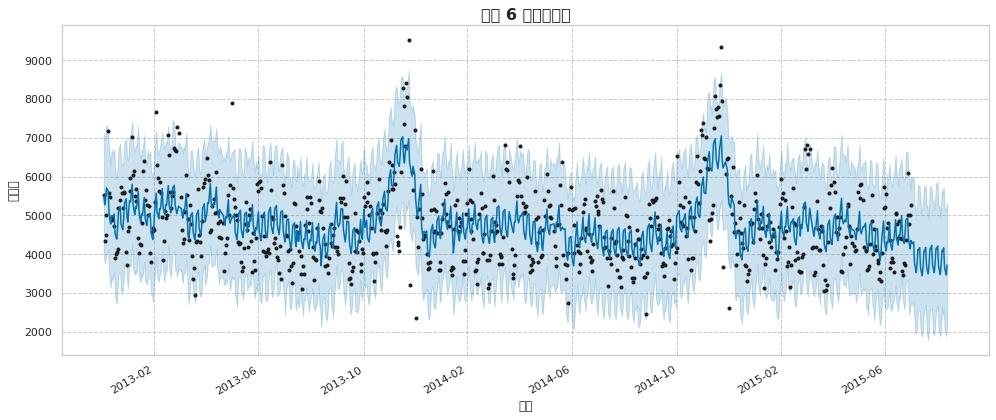

In [59]:
import matplotlib.pyplot as plt

# 默认 Prophet 自带的绘图
fig = my_model.plot(forecast)

# 美化处理
fig.set_size_inches(14, 6)  # 放大图像
ax = fig.gca()              # 获取当前坐标轴

# 设置标题 & 标签
ax.set_title("未来 6 周销售预测", fontsize=16, fontweight='bold')
ax.set_xlabel("日期", fontsize=12)
ax.set_ylabel("销售额", fontsize=12)

# 设置网格线和背景
ax.grid(True, linestyle='--', alpha=0.4)

# x 轴日期格式美化（可选）
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


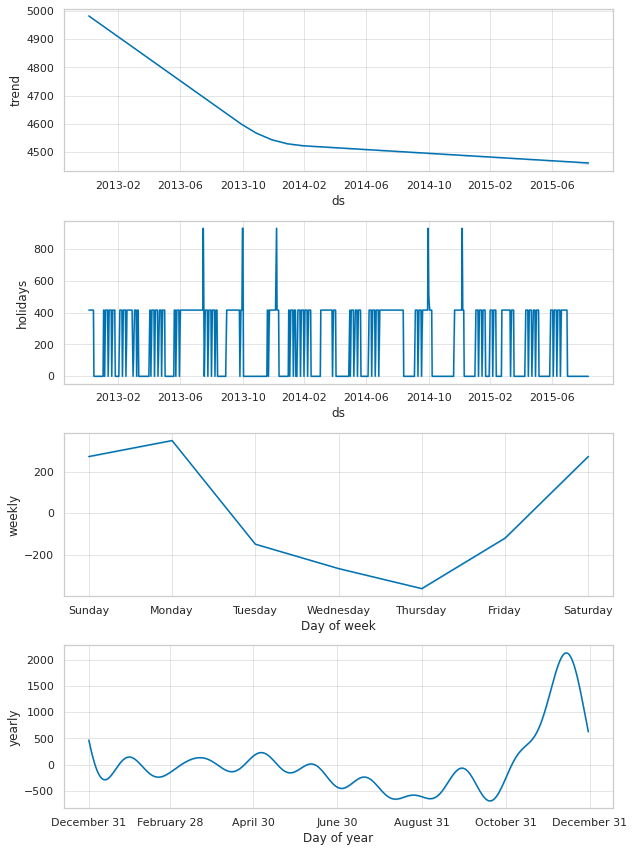

In [60]:
my_model.plot_components(forecast);

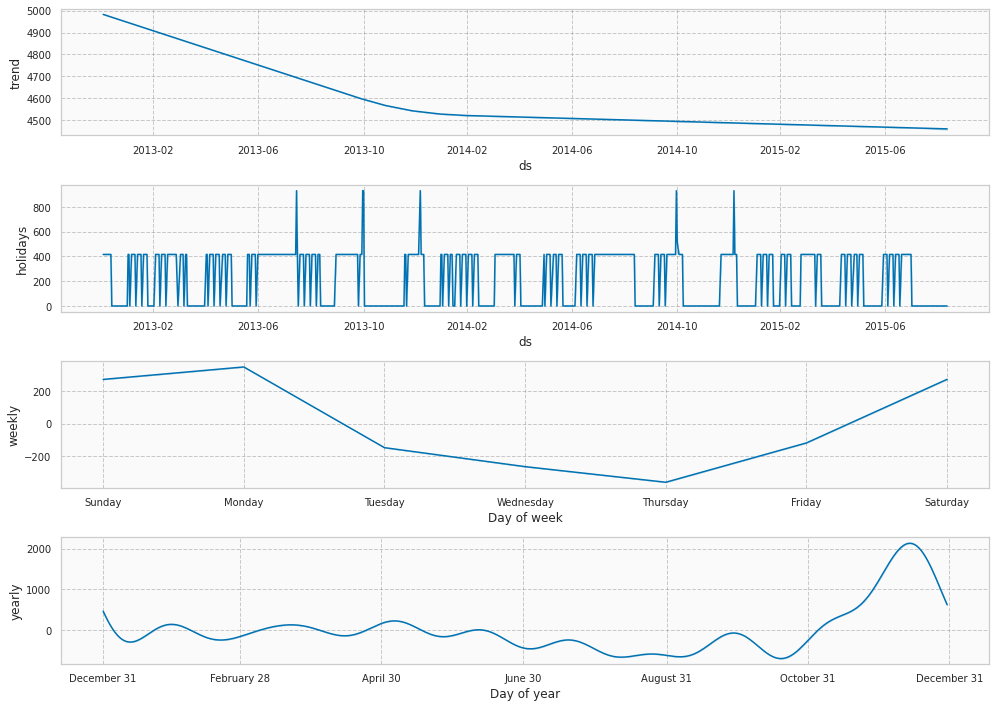

In [61]:
import matplotlib.pyplot as plt

# 默认组件图
fig = my_model.plot_components(forecast)

# 设置图像整体尺寸
fig.set_size_inches(14, 10)  # 更大更清晰

# 获取所有子图
axes = fig.get_axes()

# 修改每个子图样式
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.4)     # 添加淡淡的网格线
    ax.set_facecolor('#FAFAFA')                 # 设置背景色为浅灰
    ax.title.set_fontsize(14)                   # 调整标题字体大小
    ax.title.set_fontweight('bold')             # 标题加粗
    ax.tick_params(axis='both', labelsize=10)   # 坐标轴刻度字体调小一点
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

# 紧凑排版防止重叠
plt.tight_layout()
plt.show()
